# Comparing the power-law collision kernels with jump kernels of subordinate processes. 

In [1]:
include("collisionkernels.jl")
using .CollisionKernels

include("subordinate.jl")
using .Subordinate

using Plots
println("You are using ",Threads.nthreads()," threads. For maximum performance, this number should be near the number of CPU cores that you have in your computer.")

You are using 10 threads. For maximum performance, this number should be near the number of CPU cores that you have in your computer.


In [54]:
function draw_nice_pic(νs::Vector{<:Real}, focus::Integer, s1::Array)
    @assert 1 <= focus <= size(s1)[1]
    println("ν = ",νs[focus])
    q = qofν(νs[focus])
    cq = Cq(q)
    cν = Cnu(νs[focus])
    θr = range(π/(P+1),π/2,length=P)
    θrange = range(π/(P+1),π/2,length=100)
    brange = map(θ->symb(θ,q),θrange)
    srange = cq/cν * s1[focus,:]
    plot(θr,(srange),label="b_{sub}", yaxis=:log)
    p2 = plot!(θrange,(brange),label="b_{col}", yaxis=:log)
    display(p2)
    println("Graph for ν=", νs[focus]," in logarithmic scale")
end

function do_everything(P::Integer, νs::Vector{<:Real}, ω::Function)
    println("Computing the Fourier coefficients of the bump functions")
    @time a,m = pre_sample(P)
    println("Evaluating the integral operator at each bump function and sampling the kernel")
    @time s1 = sample_subordinate(νs,ω,a,m)

    for m in 1:length(νs)
        ν = νs[m]
        cν = Cnu(ν)
        qf = qofν(ν)
        cfq = Cq(qf)
    
        min = 1.
        max = 1.
        for i in 2:P
            θ = (1+i)/(P+1) * π/2
            ratio = s1[m,i] / cν / symb(θ,qf) * cfq
            if ratio<min
                min = ratio
            end
            if ratio>max
                max = ratio
            end
        end
        println("ν= ",ν,"   min ratio:",min/max)
    end

    println()
    println("Drawing some pictures")
    println()
    
    draw_nice_pic(νs,1,s1)
    draw_nice_pic(νs,length(νs),s1)
end;

Let $b_{col}(\theta)$ be the collision kernel corresponding to a power-law repulsive force with exponent $q$. These kernels are known to have the following behavior for small angles.
$$ b_{col}(\theta) = C_q \theta^{-2-\nu}. $$
The exact formula for $b_{col}$ is not explicit. We want to compare it with a kernel $b_{sub}$ of the form
$$ b_{sub}(\theta) = \int_0^\infty \omega(t) h_t(\theta).$$
Here $h_t$ is the heat kernel centered at the north pole $\theta=0$. The weight $\omega(t)$ is an arbitrary weight function. We proved that for any such kernel $b_{sub}$, the inequality (1.4) in our paper holds with constant $\Lambda_{sub} = \min(2\Lambda_{local},2d)$, which is equal to 6 in dimension three.

We want to apply the followig fact. If for any weight $\omega \geq 0$, we find two constants $c_1$ and $C_2$ such that
$$c_1 (b_{sub}(\theta) + b_{sub}(\pi-\theta)) \leq (b_{col}(\theta)+b_{col}(\pi-\theta)) \leq C_2 (b_{sub}(\theta) + b_{sub}(\pi-\theta)),$$
then the inequality (1.4) holds for $b_{col}$ with parameter $C_2/c_1 \cdot 6$.

The plan is to compute $b_{col}$ and $b_{sub}$ numerically some weight. The best one I have been able to find for the range $\nu \in [1.5,2)$ so far is
$$ \omega(t) := t^{-1-\nu/2} \left( 1 - \min(13/8 - 3/4 ν, 0.4)(1-\exp(-2t)) \right).$$
We then estimate the value of $C_2/c_1$ for a collection of values of $\nu \in [1,2]$.

To draw the graphs, we renormalize $b_{sub}$ so that it has the same asymptotic behavior as $b_{col}$ at $\theta = 0$.

The blue line corresponds to the kernel $b_{sub}$ renormalized. The red line is the kernel $b_{col}$. In most of the graphs the lines are one of top of the other. We can barely recognize there are two distinct curves.

The graphs are in logarithmic scale.

Computing the Fourier coefficients of the bump functions
  3.662379 seconds (190.05 M allocations: 3.692 GiB, 8.65% gc time)
Evaluating the integral operator at each bump function and sampling the kernel
  1.159742 seconds (1.50 M allocations: 63.413 MiB, 898.94% compilation time: 10% of which was recompilation)
ν= 1.5   min ratio:0.9814556715674014
ν= 1.6   min ratio:0.9699283020606919
ν= 1.7   min ratio:0.974854759372646
ν= 1.8   min ratio:0.9855072199105359
ν= 1.9   min ratio:0.985298836119929
ν= 1.925   min ratio:0.9848726297380741
ν= 1.95   min ratio:0.9846774122363147
ν= 1.975   min ratio:0.9836091353203944
ν= 1.99   min ratio:0.9819618770364207
ν= 1.999   min ratio:0.9808208577834986

Drawing some pictures

ν = 1.5


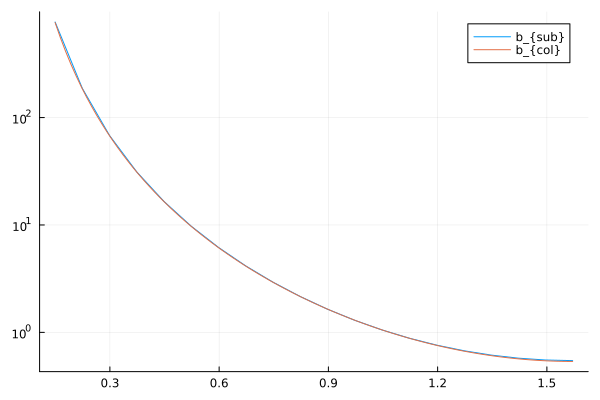

Graph for ν=1.5 in logarithmic scale
ν = 1.999


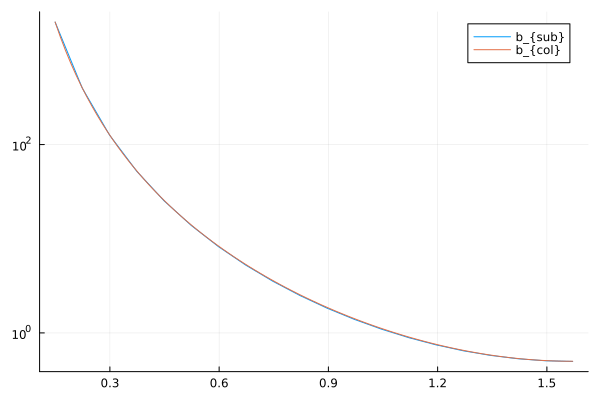

Graph for ν=1.999 in logarithmic scale


In [55]:
# This is the only cell you may want to edit unless you know what you are doing.

# P is the number of points used in the sample of the subordinate kernel
# The subordinate kernel will be compared with the collision kernel at P equidistant points between 0 and π/2
# The computation is slow. Do not make P too large.
# P=25 should give a reasonably accurate computation. The computation takes about 45 seconds on my laptop. 
# For P=10, you would be able to see the blue curve as a polygonal. But it is computed quickly (15 seconds).
# Higher values of P provide a better fitting near θ=0
# P = 30
P = 20

# This is the list of values of ν for which we will sample the ratio between kernels
# Be aware that if you choose ν too close to 2, strange things may happen due to numerical error.
νs = [1.5,1.6,1.7,1.8,1.9,1.925,1.95,1.975,1.99,1.999] #,1.9999]
# νs = [1.5,1.9,1.99]

# This is the function ω that we use to produce the subordinate kernel.
# It will be multiplied time t^(-1-ν/2)
# ω(t,ν) = 1/sqrt(1+(2*(2-ν)+(2-ν)^2/2)*t)
# ω(t,ν) = 1/sqrt(1+(2*(2-ν)+(2-ν)^2/2)*t)
ω(t,ν) = 1 - min(13/8 - 3/4 * ν, 0.4)*(1-exp(-2t))

do_everything(P,νs,ω)

In [4]:
# We also want to estimate the values of $c_K$ and $C_P$ for these kernels.
using QuadGK

Λlocal = 5.5

function compute_cK(ν::Real, ω::Function)
    factor = Subordinate.subordinate_factor(ν)
    Cν = 1/(2*factor)
    return quadgk(t -> Cν*ω(t)*t^(-1-ν/2)*(1-exp(-2Λlocal *t)),0,Inf)[1]
end

function compute_cP(ν::Real, ω::Function)
    factor = Subordinate.subordinate_factor(ν)
    Cν = 1/(3*factor)
    return quadgk(t -> Cν*ω(t)*t^(-1-ν/2)*(1-exp(-6 *t)),0,Inf)[1]
end

function compute_Λb(ν::Real, ω::Function)
    return 2*compute_cK(ν,ω) / compute_cP(ν,ω)
end

compute_Λb (generic function with 1 method)

In [5]:
ν = 1.5
println("For ν = ",ν)
println("cK= ",compute_cK(ν,t->ω(t,ν)),"  cP= ",compute_cP(ν,t->ω(t,ν)), "   Λb=",compute_Λb(ν,t->ω(t,ν)))

For ν = 1.5
cK= 2.854349755938035  cP= 1.1787540226358428   Λb=4.842994723454429


Computing the Fourier coefficients of the bump functions
 11.439830 seconds (429.28 M allocations: 8.331 GiB, 6.52% gc time)
Evaluating the integral operator at each bump function and sampling the kernel
  1.161731 seconds (697.79 k allocations: 36.523 MiB, 914.42% compilation time: 10% of which was recompilation)
ν= 1.5   max ratio:1.4009473686306826

Drawing some pictures

ν = 1.5


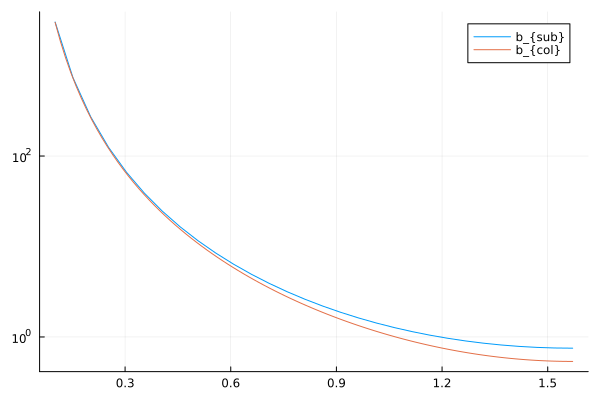

Graph for ν=1.5 in logarithmic scale
ν = 1.5


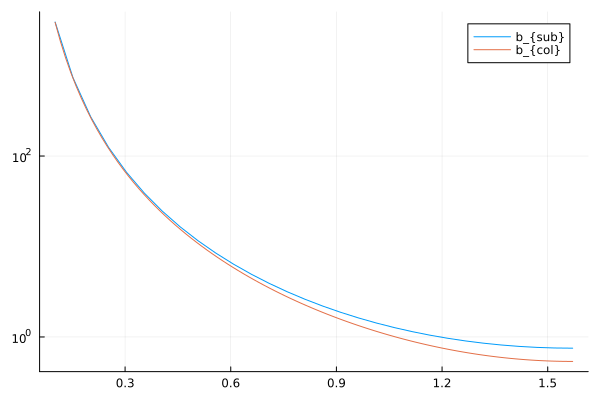

Graph for ν=1.5 in logarithmic scale


In [52]:
νs = [3/2]
P = 30
ω(t,ν) = 1.
do_everything(P,νs,ω)

In [53]:
1 / 1.4

0.7142857142857143